In [13]:
# Import library yang dibutuhkan
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

In [14]:
# Konfigurasi parameter untuk model dan data
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_DIR = 'batik_jogja' # Pastikan folder ini ada di direktori yang sama
LEARNING_RATE = 0.001
EPOCHS = 10 # Anda bisa menambahkannya untuk akurasi yang lebih baik

# URL model EfficientNet-Lite0 dari TensorFlow Hub
HUB_MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

In [15]:
print("Memuat dataset dari direktori...")

# Dataset untuk training (80% dari data)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=123
)

# Dataset untuk validasi (20% dari data)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Simpan nama kelas
class_names = np.array(train_dataset.class_names)
num_classes = len(class_names)
print("\nKelas yang ditemukan:", class_names)

Memuat dataset dari direktori...
Found 1350 files belonging to 6 classes.
Using 1080 files for training.
Found 1350 files belonging to 6 classes.
Using 270 files for validation.

Kelas yang ditemukan: ['batik_ceplok' 'batik_kawung' 'batik_nitik' 'batik_parang'
 'batik_sidoluhur' 'batik_truntum']


In [16]:
# Menggunakan cache dan prefetch untuk mempercepat loading data saat training
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\nDataset siap digunakan.")


Dataset siap digunakan.


In [17]:
# Cell 5: Membangun Model (Menggunakan Model Subclassing - SOLUSI FINAL)

print("Membangun model Keras dengan metode Subclassing...")

# 1. Definisikan arsitektur model di dalam sebuah class turunan dari tf.keras.Model
class BatikLiteModel(tf.keras.Model):
  def __init__(self, num_classes):
    super().__init__()
    # Definisikan semua layer yang dibutuhkan di sini
    self.feature_extractor = hub.KerasLayer(
        HUB_MODEL_URL,
        trainable=False,
        name='efficientnet_lite0_base'
    )
    self.dropout_layer = tf.keras.layers.Dropout(0.2)
    self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

  # Definisikan alur maju (forward pass) data di dalam method 'call'
  def call(self, inputs):
    x = self.feature_extractor(inputs)
    x = self.dropout_layer(x)
    x = self.output_layer(x)
    return x

# 2. Buat sebuah instance (objek) dari class model yang baru kita buat
model = BatikLiteModel(num_classes=num_classes)

# 3. (Penting) Panggil `build` agar model tahu bentuk inputnya dan .summary() bisa ditampilkan
model.build((None,) + IMG_SIZE + (3,))

# Tampilkan ringkasan arsitektur model
model.summary()

Membangun model Keras dengan metode Subclassing...


c:\Users\Noval.DESKTOP-G118GKA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'batik_lite_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "batik_lite_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Kompilasi model dengan optimizer, loss function, dan metrik
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mulai proses pelatihan
print(f"\nMemulai pelatihan model untuk {EPOCHS} epoch...")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)


Memulai pelatihan model untuk 10 epoch...
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 442ms/step - accuracy: 0.3678 - loss: 1.6156 - val_accuracy: 0.5963 - val_loss: 1.2180
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.6336 - loss: 1.1005 - val_accuracy: 0.6481 - val_loss: 1.0279
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.6862 - loss: 0.9382 - val_accuracy: 0.6889 - val_loss: 0.9378
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 483ms/step - accuracy: 0.7165 - loss: 0.8421 - val_accuracy: 0.6963 - val_loss: 0.8840
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - accuracy: 0.7392 - loss: 0.7789 - val_accuracy: 0.7296 - val_loss: 0.8465
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 408ms/step - accuracy: 0.7581 - loss: 0.7313 - val_accuracy: 0.7370 - val_loss: 0.8184
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.7690 - loss: 0.6926 - val_accuracy: 0.7370 - val_loss: 0.7961
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step -

In [19]:
print("\nMenghitung dan Menampilkan Metrik Evaluasi pada Validation Set...")

y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

predictions = model.predict(validation_dataset)
y_pred = np.argmax(predictions, axis=1)

print("\n--- Laporan Klasifikasi (Classification Report) ---")
print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"\nSkor Akurasi Keseluruhan: {accuracy:.4f} ({accuracy:.2%})")
print(f"Skor Presisi (Weighted): {precision:.4f}")
print(f"Skor Recall (Weighted): {recall:.4f}")

acc = history.history['accuracy']


Menghitung dan Menampilkan Metrik Evaluasi pada Validation Set...
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step

--- Laporan Klasifikasi (Classification Report) ---
                 precision    recall  f1-score   support

   batik_ceplok       0.79      0.68      0.73        38
   batik_kawung       0.74      0.73      0.74        48
    batik_nitik       0.77      0.60      0.67        57
   batik_parang       0.93      0.88      0.90        43
batik_sidoluhur       0.60      0.89      0.72        36
  batik_truntum       0.71      0.77      0.74        48

       accuracy                           0.75       270
      macro avg       0.76      0.76      0.75       270
   weighted avg       0.76      0.75      0.75       270


Skor Akurasi Keseluruhan: 0.7481 (74.81%)
Skor Presisi (Weighted): 0.7610
Skor Recall (Weighted): 0.7481


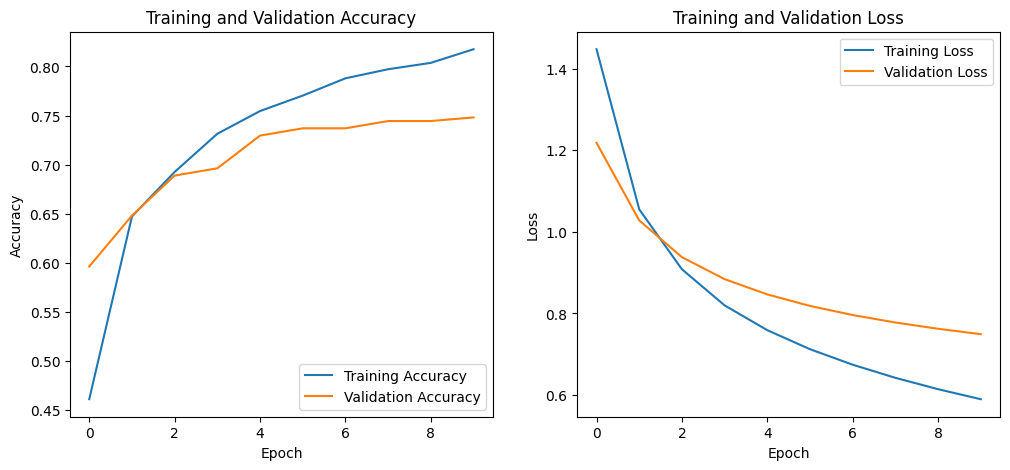

In [20]:
# Mengambil data histori pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Membuat plot untuk Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Membuat plot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Tampilkan plot
plt.show()

In [21]:
# Simpan model yang sudah dilatih ke dalam file .h5
NEW_MODEL_PATH = 'batik_lite_model2.h5'
print(f"\nMenyimpan model yang telah dilatih ke '{NEW_MODEL_PATH}'...")

model.save(NEW_MODEL_PATH)

print("Model baru berhasil disimpan!")


Menyimpan model yang telah dilatih ke 'batik_lite_model2.h5'...
Model baru berhasil disimpan!
